Evaluation of multilabel trained model

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
#Paths & Parameters
MODEL_PATH = "/content/drive/MyDrive/irmas_multilabel_cnn.keras"
LABELS_CSV = "/content/drive/MyDrive/multilabel_labels.csv"
MEL_DIR = "/content/drive/MyDrive/irmas_multilabel_mels"

IMG_SIZE = 128

In [ ]:
#Load Trained Model
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully")

✅ Model loaded successfully


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#Load Dataset (Images + Labels)
labels_df = pd.read_csv(LABELS_CSV)

X, y = [], []

for _, row in labels_df.iterrows():
    img_path = os.path.join(MEL_DIR, row["file"].replace(".wav", ".png"))
    if not os.path.exists(img_path):
        continue

    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0

    X.append(img)
    y.append(row[1:].values.astype("float32"))

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000, 128, 128, 3)
y shape: (1000, 11)


In [ ]:
#Train / Validation Split (for evaluation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
#Keras Evaluation Metrics
loss, binary_acc, precision, recall = model.evaluate(X_val, y_val)

print("\n=== KERAS EVALUATION ===")
print("Loss:", loss)
print("Binary Accuracy:", binary_acc)
print("Precision:", precision)
print("Recall:", recall)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - binary_accuracy: 0.7825 - loss: 0.4984 - precision_2: 0.7238 - recall_2: 0.0417

=== KERAS EVALUATION ===
Loss: 0.5006890296936035
Binary Accuracy: 0.7809090614318848
Precision: 0.7083333134651184
Recall: 0.03455284610390663


In [ ]:
#Threshold-based Evaluation (IMPORTANT for multilabel)
y_pred = model.predict(X_val)

THRESHOLD = 0.3
y_pred_bin = (y_pred >= THRESHOLD).astype(int)

precision_t = precision_score(y_val, y_pred_bin, average="micro")
recall_t = recall_score(y_val, y_pred_bin, average="micro")
f1_t = f1_score(y_val, y_pred_bin, average="micro")

print("\n=== THRESHOLD-BASED METRICS ===")
print("Threshold:", THRESHOLD)
print("Precision:", precision_t)
print("Recall:", recall_t)
print("F1-Score:", f1_t)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step

=== THRESHOLD-BASED METRICS ===
Threshold: 0.3
Precision: 0.3582089552238806
Recall: 0.43902439024390244
F1-Score: 0.39452054794520547


In [ ]:
#Test multiple thresholds:

for t in [0.2, 0.3, 0.4, 0.5]:
    y_bin = (y_pred >= t).astype(int)
    f1 = f1_score(y_val, y_bin, average="micro")
    print(f"Threshold {t} → F1: {f1:.3f}")

Threshold 0.2 → F1: 0.421
Threshold 0.3 → F1: 0.395
Threshold 0.4 → F1: 0.204
Threshold 0.5 → F1: 0.066


In [ ]:
#FINAL_THRESHOLD = 0.2
FINAL_THRESHOLD = 0.2
y_pred_bin = (y_pred >= FINAL_THRESHOLD).astype(int)

precision = precision_score(y_val, y_pred_bin, average="micro")
recall = recall_score(y_val, y_pred_bin, average="micro")
f1 = f1_score(y_val, y_pred_bin, average="micro")

print("Final Threshold:", FINAL_THRESHOLD)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Final Threshold: 0.2
Precision: 0.2796780684104628
Recall: 0.8475609756097561
F1-score: 0.4205748865355522


After threshold analysis, 0.2 was selected as the final decision threshold and used for reporting performance.

In [ ]:
#Generate prediction probabilities (VALIDATION)
y_pred_prob = model.predict(X_val)
print(y_pred_prob.shape)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step
(200, 11)


In [ ]:
#Thresholding (VALIDATION)
THRESHOLD = 0.2
y_pred_bin = (y_pred_prob >= THRESHOLD).astype(int)

In [ ]:
#Define instruments
INSTRUMENTS = [
    "cello", "clarinet", "flute", "guitar", "organ",
    "piano", "saxophone", "trumpet", "violin", "voice", "others"
]

In [ ]:
#Per-class Confusion Matrix
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(y_val, y_pred_bin)

for i, inst in enumerate(INSTRUMENTS):
    print(f"\nConfusion Matrix for {inst}")
    print(cm[i])


Confusion Matrix for cello
[[ 38 119]
 [  2  41]]

Confusion Matrix for clarinet
[[110  51]
 [ 19  20]]

Confusion Matrix for flute
[[63 85]
 [ 7 45]]

Confusion Matrix for guitar
[[65 95]
 [ 5 35]]

Confusion Matrix for organ
[[55 92]
 [ 8 45]]

Confusion Matrix for piano
[[67 87]
 [10 36]]

Confusion Matrix for saxophone
[[ 47 110]
 [  3  40]]

Confusion Matrix for trumpet
[[  6 145]
 [  2  47]]

Confusion Matrix for violin
[[111  52]
 [ 16  21]]

Confusion Matrix for voice
[[ 16 135]
 [  0  49]]

Confusion Matrix for others
[[ 56 103]
 [  3  38]]


In [ ]:
#Metrics Matrix (precision, recall, f1, accuracy)
#Overall (micro-average)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_val, y_pred_bin, average="micro")
recall    = recall_score(y_val, y_pred_bin, average="micro")
f1        = f1_score(y_val, y_pred_bin, average="micro")

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.2796780684104628
Recall: 0.8475609756097561
F1-score: 0.4205748865355522


In [ ]:
#Per-class metrics (VERY IMPORTANT)
from sklearn.metrics import classification_report

print(classification_report(
    y_val,
    y_pred_bin,
    target_names=INSTRUMENTS,
    zero_division=0
))

              precision    recall  f1-score   support

       cello       0.26      0.95      0.40        43
    clarinet       0.28      0.51      0.36        39
       flute       0.35      0.87      0.49        52
      guitar       0.27      0.88      0.41        40
       organ       0.33      0.85      0.47        53
       piano       0.29      0.78      0.43        46
   saxophone       0.27      0.93      0.41        43
     trumpet       0.24      0.96      0.39        49
      violin       0.29      0.57      0.38        37
       voice       0.27      1.00      0.42        49
      others       0.27      0.93      0.42        41

   micro avg       0.28      0.85      0.42       492
   macro avg       0.28      0.84      0.42       492
weighted avg       0.28      0.85      0.42       492
 samples avg       0.29      0.85      0.42       492



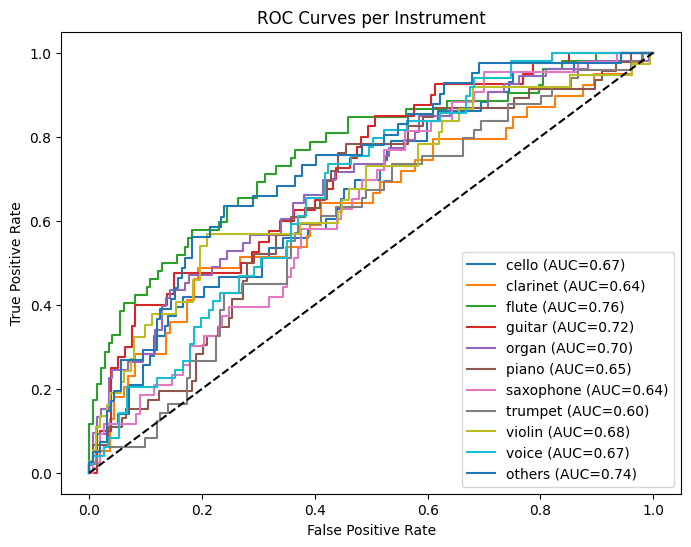

In [ ]:
#ROC Curve + AUC (per instrument)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for i, inst in enumerate(INSTRUMENTS):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{inst} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Instrument")
plt.legend()
plt.show()